In [355]:
import numpy as np
import pandas as pd
import sqlite3 as sql
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline

#Need to set the 'PROJ_LIB' location to use projections in Basemap
import os
os.environ['PROJ_LIB'] = '/anaconda3/pkgs/proj4-5.2.0-h0a44026_1/share/proj/'
from mpl_toolkits.basemap import Basemap as bmp

# Oregon Timber Performance and Wildfire Analysis

## Data Background
     This data comes from the Oregon Department of Forestry (ODF) and US Fire Program Analysis system (Short, 2017). The dataset provides information regarding timber harvests from 1962-2017, log prices from 2000-2015, and wildfire occurences for the United States from 1992-2015. Log prices are listed as a pond value (price/log in a mills holding pond) for given species and grades of logs as defined by the ODF. By combining these datasets I can take an interesting look at how natural or induced processes could be disrupting the supply and price structure of a major industry in Oregon. Considering that Oregon is the #1 producer of lumber in the US, wildfire affects on pricing and supply could have larger effects on the industry nation wide.

## Analytic Questions
    1.) Where are the top performing regions in Oregon and what have the primary species been from 1962-2015?
    2.) How have log prices changed from 2000-2016 for the different species in the dataset and for all logs?
    3.) Are the occurences of wildfires increasing in Oregon? Are there prolific logging regions that are also more
        prone to wildfires than others?

## Future Research Questions
    The combination of these three datasets will be used to predict future log prices for given species, evaluate the effect regional wildfires have on timber supply, and predict log prices in years where the supply is affected by wildfires.


## References
Short, Karen C. 2017. Spatial wildfire occurrence data for the United States, 1992-2015 [FPA_FOD_20170508]. 4th Edition. Fort Collins, CO: Forest Service Research Data Archive. https://doi.org/10.2737/RDS-2013-0009.4

In [354]:
#loading the raw data into Pandas dataframe
timber_prices = pd.read_csv('Log_Prices.csv')
timber_harvest = pd.read_csv('Timber_Harvest_Data_1962-2017.csv')
#timber_prices

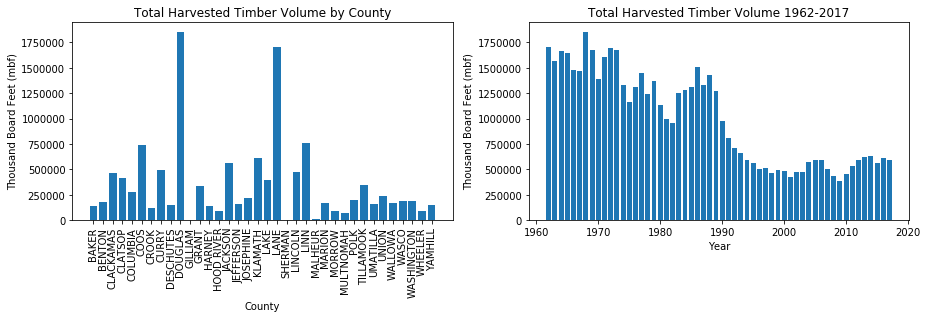

In [365]:
county_sum = timber_harvest.groupby('County').aggregate(np.sum)
#print(county_sum['Total Of Volume'])
plt.figure(figsize=(15,8))

#generating plots to identify high producing regions and the relative change in harvest volumes over time
plt.subplot(2,2,1)
plt.bar(timber_harvest['County'], timber_harvest['Total Of Volume'], width=0.8)
plt.title('Total Harvested Timber Volume by County')
plt.xlabel('County')
plt.ylabel('Thousand Board Feet (mbf)')
plt.xticks(rotation=90)

plt.subplot(2,2,2)
plt.bar(timber_harvest['Year'], timber_harvest['Total Of Volume'], width=0.8)
plt.title('Total Harvested Timber Volume 1962-2017')
plt.xlabel('Year')
plt.ylabel('Thousand Board Feet (mbf)')
plt.show()

    There are a few counties that are the primary suppliers of timber in Oregon. Douglas and Lane counties are the major suppliers, with Linn, Coos, and Klamath counties rounding out the top 5. The total amount of timber harvested in Oregon has been steadily declining since ~1989, with a few years that are stronger than others. The past 20 years have seen a resurgence in harvested volumes. Since the recession in 2008, yearly timber harvests have been as high or higher than the early 1990's. To understand how these volume shifts are represented in the market, the timber_prices dataset needs to be evaluated.

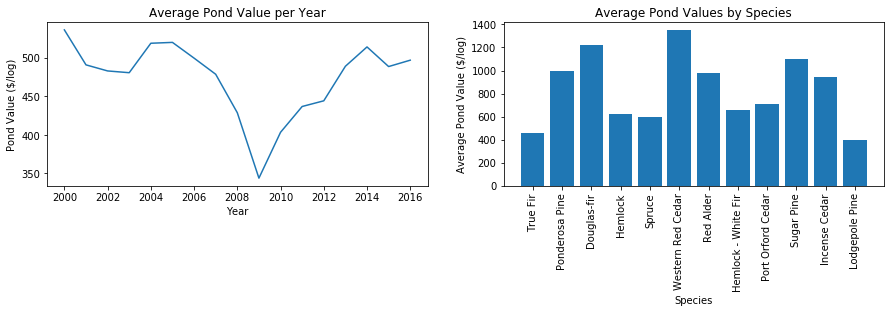

In [367]:
#averaging prices by year so that we can evaluate the prices over time
#the following plots show total average log price/year and the average value per species
timber_prices_yr = timber_prices.groupby('Year').aggregate(np.mean)

plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
plt.plot(timber_prices_yr['Pond Value'])
plt.title('Average Pond Value per Year')
plt.xlabel('Year')
plt.ylabel('Pond Value ($/log)')

plt.subplot(1,2,2)
plt.bar(timber_prices['Species'], timber_prices['Pond Value'], width=0.8)
plt.title('Average Pond Values by Species')
plt.xlabel('Species')
plt.ylabel('Average Pond Value ($/log)')
plt.xticks(rotation=90)
plt.show()

  The average price for all logs in Oregon seems to be driven heavily by the recession in 2008. Following 2009, prices rebound to pre-recession values by 2013 and are relatively constant, if not increaseing, for the next 3 years. However, each species is worth different values relative to one another and are grown in different regions in the state. In order to understand the true variability of log prices over the 17 year period, it is necessary to break up the dataframe and evaluate each species' price over time.  

In [158]:
#create empty dictionary to store species names from following for loop
log_type = {}
for spc in timber_prices['Species']:
    log_type[spc] = spc

#set the dictionary values to be timber price dataframes filtered to the species in the key    
for spc in log_type:
    log_type[spc] = timber_prices[timber_prices['Species'] == spc]

print(log_type.keys())

dict_keys(['True Fir', 'Ponderosa Pine', 'Douglas-fir', 'Hemlock', 'Spruce', 'Western Red Cedar', 'Red Alder', 'Hemlock - White Fir', 'Port Orford Cedar', 'Sugar Pine', 'Incense Cedar', 'Lodgepole Pine'])


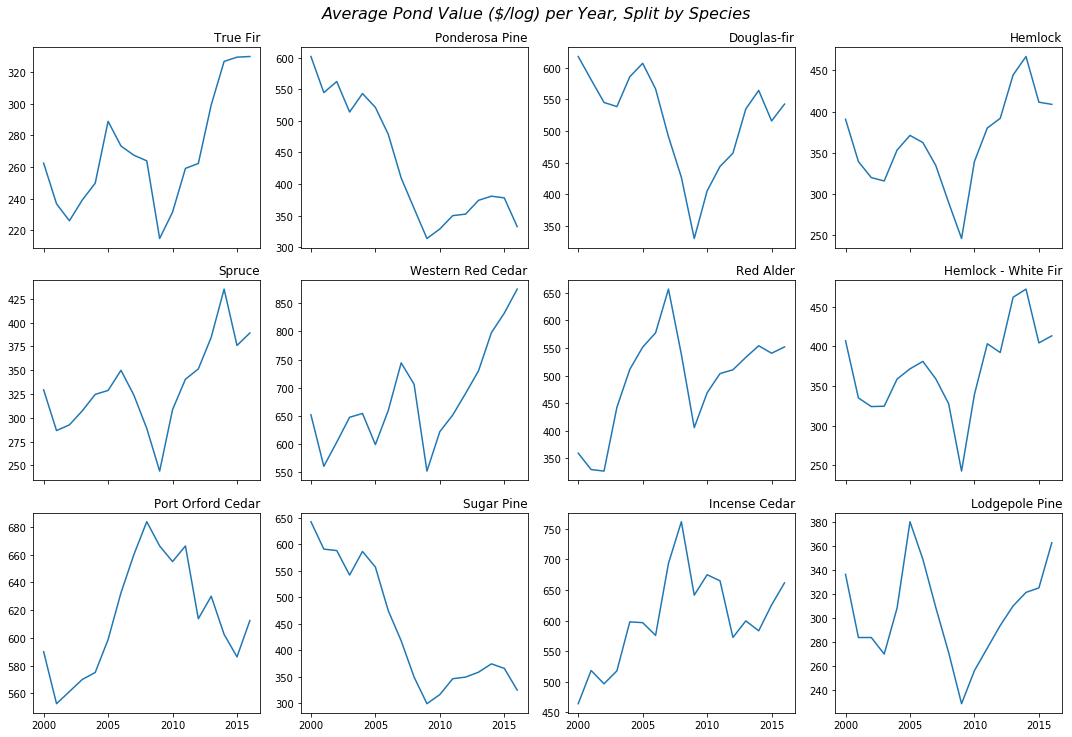

In [238]:
#create an empty dictionary to store species dataframes that are grouped by year
logspcs_price_mean = {}
for spc in log_type:
    logspcs_price_mean[spc] = log_type[spc].groupby('Year').aggregate(np.mean)    

#using a for loop to subplot the species average ($/log)/year
plt.figure(figsize=(15,10))
num = 0
for df in year_log_price_mean:
    num +=1
    plt.subplot(3,4,num)
    plt.plot(logspcs_price_mean[df]['Pond Value'])
    plt.title(df, loc='right')
    
    if num in range(9):
        plt.tick_params(labelbottom=False)
    else:
        plt.tick_params(int)
plt.suptitle('Average Pond Value ($/log) per Year, Split by Species',
             fontsize=16, color='black', style='italic', y=1.02)        
plt.tight_layout()    
plt.show()

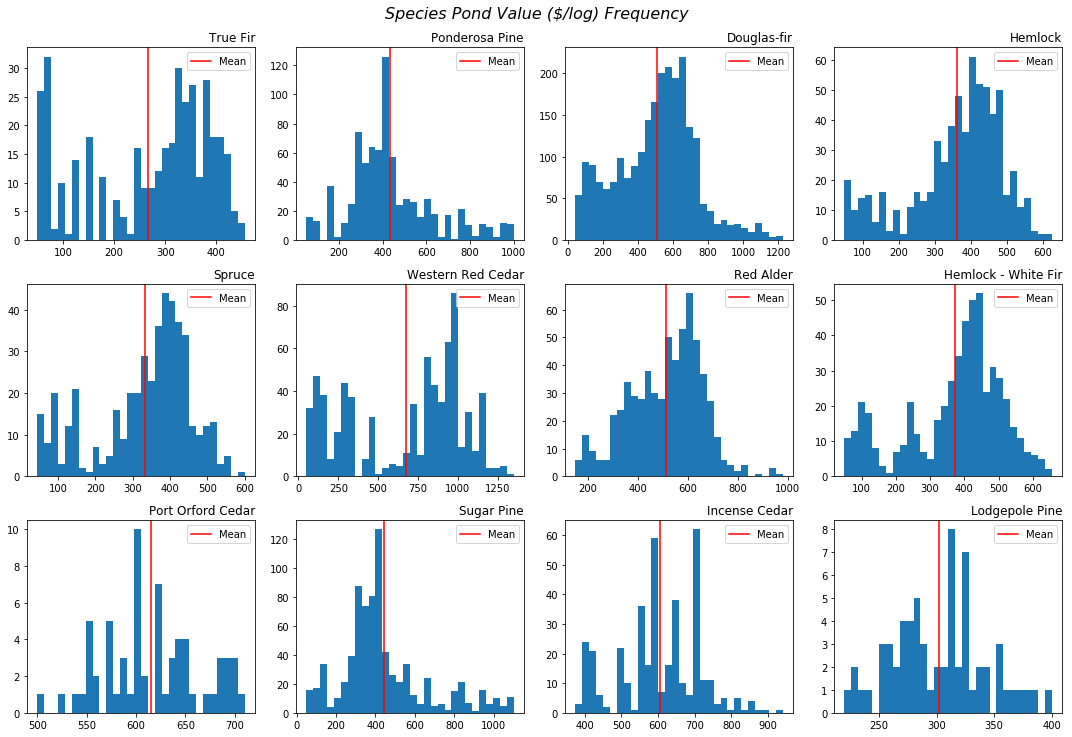

In [390]:
plt.figure(figsize=(15,10))

num = 0
for spcs in log_type:
    num += 1
    plt.subplot(3,4,num)
    plt.hist(log_type[spcs]['Pond Value'], bins=30, label=spcs)
    mean_line = plt.axvline(log_type[spcs]['Pond Value'].mean(), linestyle='solid', color='red', label='Mean')
    plt.title(spcs, loc='right')
    plt.legend(handles=[mean_line], loc='upper right')

plt.suptitle('Species Pond Value ($/log) Frequency', fontsize=16, color='black', style='italic', y=1.02)        
plt.tight_layout()    
plt.show()

    Some of the species in Oregon seem to be "recession proof", in that they saw increased value as some species saw a major drop in price. Sugar Pine, Ponderosa Pine, and Douglas Fir have decreased in value from 2000-2016. The other nine species had positive or negative price fluctuations centered around 2008, but have generally been increasing in value over time. Most of the species prices appear to be normally distributed with the mean line being close to the central clump of data. The species that do not exhibit normal tendencies seem to be bimodally distributed.

    These observations are interestng because they do not reflect the relative stability in timber prices that the dataset as a whole showed without drilling down to the different species. Because each species grows in specific regions of the state, it will be important to evaluate those regions relative fire frequency and size from 2000-2016. These trends bring up a couple of questions:

    1.) If trends in timber prices are driven by relative supply, are there enough fires to disrupt supply?
    2.) How does the frequency of fires in the timber regions change over time?
    3.) Is it the frequency of fires that are changing over time, or the size?
        a.) Which are more important for harvest volumes and price, the number of fires or the average size?
        
    In order to understand the controls on price for each species over time, a comparison to the wildfire tendencies in the top timber producing counties will be important. From there, the database will need to be filtered to the price regions and re-evaluate the prices of each species over time with the wildfire density of the region.

In [393]:
#Generating a connection to the database and querying the important columns for the project
#Most of the columns are self explanatory besides "FIPS_NAME" which is the name of the county where the fire occurred 

conn = sql.connect('1992_to_2015_wildfires.sqlite')
fire_db = pd.read_sql_query("""SELECT 
                                STATE, 
                                FIPS_NAME, 
                                FIRE_NAME, 
                                FIRE_YEAR, 
                                FIRE_SIZE, 
                                STAT_CAUSE_CODE, 
                                STAT_CAUSE_DESCR, 
                                LATITUDE, 
                                LONGITUDE 
                               FROM Fires 
                               WHERE STATE = 'OR';""", conn)
conn.close()
fire_db

,STATE,FIPS_NAME,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE
0,OR,Deschutes,0028,2005,0.10,4.0,Campfire,43.995556,-121.414167
1,OR,Deschutes,0044,2005,0.10,4.0,Campfire,44.043333,-121.386111
2,OR,Deschutes,0088,2005,0.10,4.0,Campfire,43.955556,-121.352222
3,OR,Wheeler,EARLY,2005,5.00,9.0,Miscellaneous,44.911111,-119.696111
4,OR,Deschutes,0032,2005,0.10,4.0,Campfire,43.725278,-121.574167
5,OR,Deschutes,0041,2005,0.10,5.0,Debris Burning,44.410000,-121.315556
6,OR,Lake,HALFWAY 108,2005,0.10,1.0,Lightning,42.133889,-121.234167
7,OR,Lake,PARADISE 104,2005,0.10,9.0,Miscellaneous,42.311389,-120.902778
8,OR,Lake,STUMP 106,2005,0.10,7.0,Arson,42.950833,-120.836111
9,OR,Lake,COTTONWOOD 128,2005,0.10,1.0,Lightning,42.386944,-120.808611


In [394]:
fire_db.describe()

,FIRE_YEAR,FIRE_SIZE,STAT_CAUSE_CODE,LATITUDE,LONGITUDE
count,61088.000000,61088.000000,61088.000000,61088.000000,61088.000000
mean,2003.024718,137.716104,3.137097,43.894000,-121.242887
std,7.031383,4225.904392,2.941145,1.067238,1.863912
min,1992.000000,0.010000,1.000000,41.973300,-124.548510
25%,1997.000000,0.100000,1.000000,42.977065,-122.662515
50%,2003.000000,0.100000,1.000000,43.965573,-121.584315
75%,2009.000000,0.300000,4.000000,44.750000,-119.785622
max,2015.000000,558198.300000,13.000000,46.235000,-116.485000


    Interestingly, over 75% of the fires in Oregon from 1992-2015 were less than 0.3 acres in size. Because the mean of 137 acres is greater than the median of 0.1 acres, and the distribution of fire sizes has a long tail to the right, it looks to be distributed lognormally (see histograms below).

    To confirm the lognormal distribution, the fire size was plotted in a histogram. The figure had to be truncated at 5 acres on the low side and 500 on the high side in order to display the size of the fires on the histogram. Both histograms are displayed below to show the data at both scales.

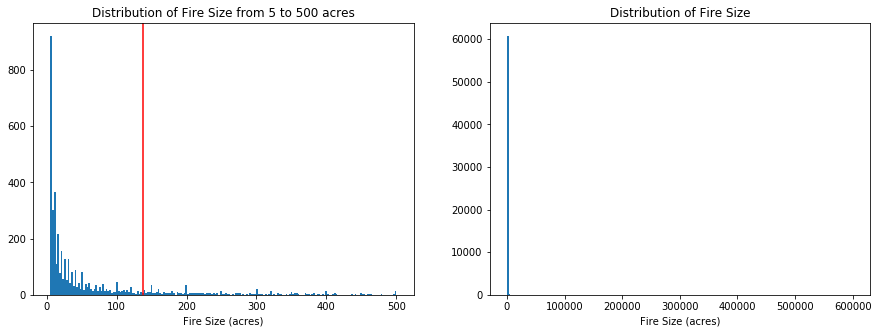

In [395]:
#Generating histogram subplots to compare the overall dataframe distribution of fire size 
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(fire_db['FIRE_SIZE'], bins=200, range=(5,500))
plt.title('Distribution of Fire Size from 5 to 500 acres')
plt.axvline(fire_db['FIRE_SIZE'].mean(), linestyle='solid', color='r')
plt.xlabel('Fire Size (acres)')

plt.subplot(1,2,2)
plt.hist(fire_db['FIRE_SIZE'], bins=200, range=(0,600000))
plt.title('Distribution of Fire Size')
plt.xlabel('Fire Size (acres)')
plt.show()

In [396]:
#group the dataframe by county and by year to understand the spatial and temporal distributions
county_fire_db = fire_db.groupby('FIPS_NAME')
year_fire_db = fire_db.groupby('FIRE_YEAR').aggregate(np.mean)

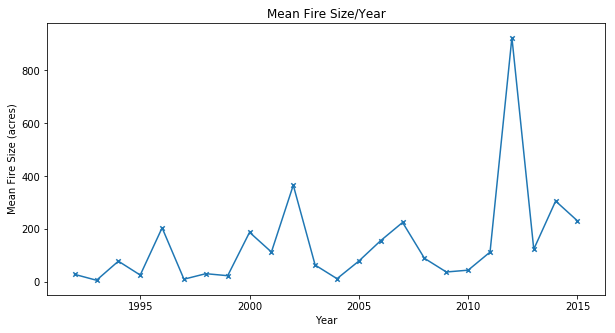

In [397]:
plt.figure(figsize=(10,5))
plt.plot(year_fire_db['FIRE_SIZE'])

plt.scatter(
    x=year_fire_db.index,
    y=year_fire_db['FIRE_SIZE'],
    marker='x',
    s=20)

plt.title('Mean Fire Size/Year')
plt.xlabel('Year')
plt.ylabel('Mean Fire Size (acres)')
plt.show()

In [398]:
print(fire_db[fire_db['FIRE_YEAR']==2012].describe())

       FIRE_YEAR      FIRE_SIZE  STAT_CAUSE_CODE     LATITUDE    LONGITUDE
count     1657.0    1657.000000      1657.000000  1657.000000  1657.000000
mean      2012.0     924.022492         4.921545    44.016351  -121.425551
std          0.0   18469.893609         3.999683     1.091839     1.877385
min       2012.0       0.010000         1.000000    41.973300  -124.495830
25%       2012.0       0.100000         1.000000    43.093889  -122.878610
50%       2012.0       0.100000         4.000000    44.095194  -121.767778
75%       2012.0       0.370000         8.000000    44.879200  -120.599589
max       2012.0  558198.300000        13.000000    46.206390  -116.600000


    Over the sampled time period the average fire size has been slightly increasing. In 2012 there was an abnormal increase in the average fire size that was due to the largest fire recorded from 1992-2015. That year did not have an abnormally large amount of fires, but is a good example of how one abnormally large datapoint can change the mean of a sample. The percentile breakouts of the 2012 fire year are consistent with the overall dataframe as well. To understand what is causing the potential increase in fire size, the dataframe could be filtered by the cause description, which could help understand if the number of natural fires are increasing over time or if they are man made.

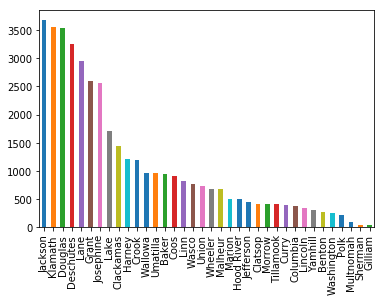

In [399]:
#creating bar chart to look at fire occurrences by county
fire_db['FIPS_NAME'].value_counts().plot('bar')
plt.show()

In [400]:
print(fire_db['FIPS_NAME'].value_counts().head(5))

Jackson      3675
Klamath      3559
Douglas      3542
Deschutes    3260
Lane         2951
Name: FIPS_NAME, dtype: int64


    Three of the top five historical timber producing counties are also in the top five counties of increased fire frequency. Klamath, Douglas, and Lane counties have been large timber producers in the past 50 years, as well as having some of the most fires. Breaking down the primary species for those counties will be very important to understand how increased fire frequency could be affecting prices or supply.

In [402]:
#storing latitude, longitude, and size datas in variables to be used in the map below
lat = fire_db['LATITUDE'].values
lon = fire_db['LONGITUDE'].values
firesize = fire_db['FIRE_SIZE'].values

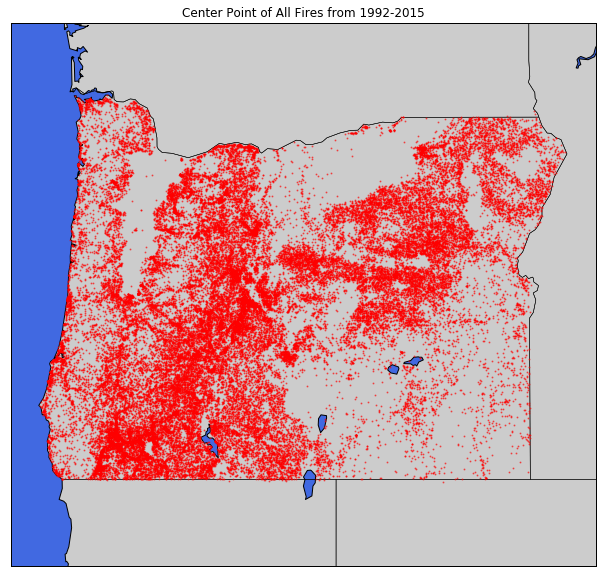

In [407]:
#basemap to visualize all wildfire occurences in dataset
plt.figure(figsize=(15,10))

m = bmp(projection='merc', 
          llcrnrlat=41,
          urcrnrlat=47,
          llcrnrlon=-125,
          urcrnrlon=-116,
          lat_ts=5,
          resolution='i')

m.drawcoastlines()
m.drawstates()
m.fillcontinents(lake_color='royalblue')
m.drawmapboundary(fill_color='royalblue')

#data is unfiltered and inclusive of all fires regardless of size
m.scatter(lon, lat, latlon=True, marker='o', color='red', s=1, alpha=0.5, zorder=10)
plt.title('Center Point of All Fires from 1992-2015')
plt.show()

    There are a large number of fires across the state, with a high density on the southwestern corner of the state. As the fire database gets broken down further, it will be good to break out the fire occurrences based on size, county, and timber producing regions.

In [408]:
#splitting main dataframe into separate dataframes by their county name
#breaking them into the counties will make it easier to evaluate specific species and regions compared to the fires

counties_fires = {}
for county in fire_db['FIPS_NAME']:
    counties_fires[county] = fire_db[fire_db['FIPS_NAME']==county]

In [409]:
print(counties_fires.keys())

dict_keys(['Deschutes', 'Wheeler', 'Lake', 'Union', 'Grant', 'Harney', 'Clackamas', 'Klamath', 'Morrow', 'Crook', 'Jefferson', 'Hood River', 'Wasco', 'Tillamook', 'Coos', 'Douglas', 'Lane', None, 'Umatilla', 'Linn', 'Marion', 'Jackson', 'Multnomah', 'Lincoln', 'Wallowa', 'Josephine', 'Curry', 'Baker', 'Malheur', 'Sherman', 'Benton', 'Yamhill', 'Gilliam', 'Washington', 'Polk', 'Columbia', 'Clatsop'])


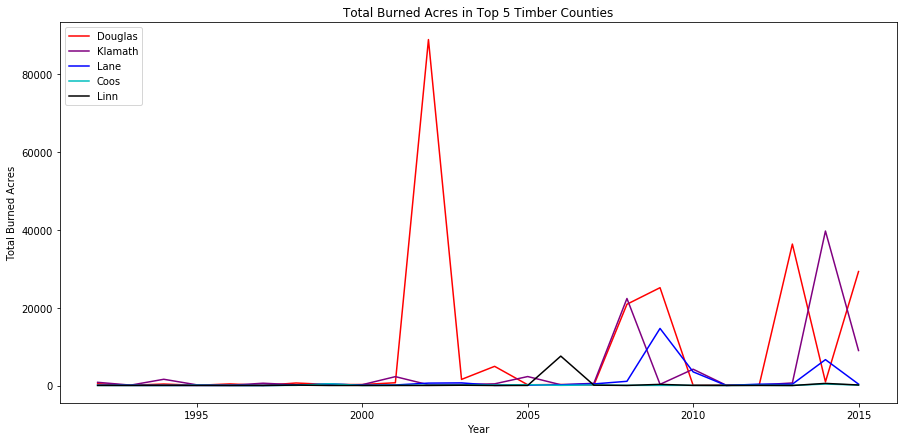

In [410]:
douglas_year_sum = counties_fires['Douglas'].groupby(['FIRE_YEAR']).aggregate(np.sum)
klamath_year_sum = counties_fires['Klamath'].groupby(['FIRE_YEAR']).aggregate(np.sum)
lane_year_sum = counties_fires['Lane'].groupby(['FIRE_YEAR']).aggregate(np.sum)
coos_year_sum = counties_fires['Coos'].groupby(['FIRE_YEAR']).aggregate(np.sum)
linn_year_sum = counties_fires['Linn'].groupby(['FIRE_YEAR']).aggregate(np.sum)

plt.figure(figsize=(15,7))
plt.plot(douglas_year_sum['FIRE_SIZE'], color='r', label='Douglas')
plt.plot(klamath_year_sum['FIRE_SIZE'], color='purple', label='Klamath')
plt.plot(lane_year_sum['FIRE_SIZE'], color='b', label='Lane')
plt.plot(coos_year_sum['FIRE_SIZE'], color='c', label='Coos')
plt.plot(linn_year_sum['FIRE_SIZE'], color='k', label='Linn')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Total Burned Acres')
plt.title('Total Burned Acres in Top 5 Timber Counties')
plt.show()

    Klamath, Douglas, and Lane counties have seen peaks in total burned area in the late 2000's and from 2013 to 2015. The increases in total burned acres is coincidental with some species increase in log price in the same time frame. The data indicates there could be a correlation between wildfires and price. Breaking down price and harvest data into the regions that correspond to an increase in wildfire density will start to lay the framework for predictive modeling in the latter parts of the project. To understand the distribution of price in the counties with large amounts of burned acreage, the timber_price dataframe needs to be broken up into the timber pond regions.

In [285]:
#replacing regions that were entered incorrectly
timber_prices.replace({'Region':{'6 - Klamath Unit':'5 - Klamath Unit', '7 - Klamath Unit':'5 - Klamath Unit'}},
                       inplace=True)

#use the str.strip() method to remove extra whitespace at the end of the region names
#creating dataframes for each region to evaluate price and species
price_region = {}
for region in timber_prices['Region'].str.strip():
    price_region[region] = timber_prices[timber_prices['Region'] == region]

print(price_region.keys())

dict_keys(['5 - Klamath Unit', '4 - Grants Pass Unit', '1 - Northwest Oregon & Willamette', '2 & 3 - Coos, Douglas Counties & Roseburg'])


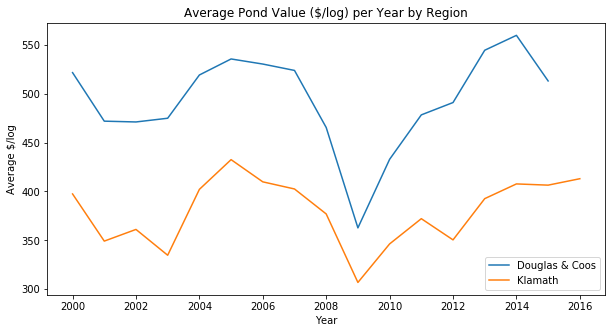

In [293]:
douglas_coos_year = price_region['2 & 3 - Coos, Douglas Counties & Roseburg'].groupby('Year').aggregate(np.mean)
klamath_unit_year = price_region['5 - Klamath Unit'].groupby('Year').aggregate(np.mean)

plt.figure(figsize=(10,5))

plt.plot(douglas_coos_year['Pond Value'], label='Douglas & Coos')
plt.plot(klamath_unit_year['Pond Value'], label='Klamath')
plt.legend(loc='lower right')
plt.title('Average Pond Value ($/log) per Year by Region')
plt.xlabel('Year')
plt.ylabel('Average $/log')
plt.show()

    The two regions selected correspond to 3 of the counties that have seen the highest wildfire rates from 2000-2015. The average prices in these regions largely reflect the same trends that are seen from the database as a whole. A p-test and t-value can be calculated for the two regions and compared to one another to see if there is a statistically significant difference between the two regions prices for all species.

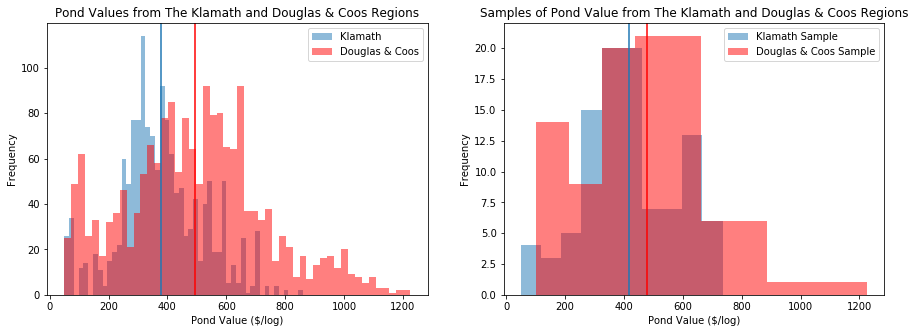

The Klamath region has a mean of: 379.60878517501715
The Douglas & Coos region has a mean of: 492.2163515016685
Ttest_indResult(statistic=-2.400898759578818, pvalue=0.017364730330954852)


In [414]:
klamath_pond = price_region['5 - Klamath Unit']['Pond Value']
douglas_coos_pond = price_region['2 & 3 - Coos, Douglas Counties & Roseburg']['Pond Value']
klamath_sample = np.random.choice(klamath_pond, 100, replace=True)
douglas_coos_sample = np.random.choice(douglas_coos_pond, 100, replace=True)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(klamath_pond, bins=50, alpha=0.5, label='Klamath')
plt.hist(douglas_coos_pond, bins=50, color='red', alpha=0.5, label='Douglas & Coos')
plt.axvline(klamath_pond.mean(), linestyle='solid')
plt.axvline(douglas_coos_pond.mean(), linestyle='solid', color='red')
plt.xlabel('Pond Value ($/log)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Pond Values from The Klamath and Douglas & Coos Regions')

plt.subplot(1,2,2)
plt.hist(klamath_sample, bins=10, alpha=0.5, label='Klamath Sample')
plt.hist(douglas_coos_sample, bins=10, color='red', alpha=0.5, label='Douglas & Coos Sample')
plt.axvline(klamath_sample.mean(), linestyle='solid')
plt.axvline(douglas_coos_sample.mean(), linestyle='solid', color='red')
plt.xlabel('Pond Value ($/log)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Samples of Pond Value from The Klamath and Douglas & Coos Regions')
plt.show()

print('The Klamath region has a mean of: {}'.format(klamath_pond.mean()))
print('The Douglas & Coos region has a mean of: {}'.format(douglas_coos_pond.mean()))
print(ttest_ind(klamath_sample, douglas_coos_sample, equal_var=False))

    Both distributions overlap and the means are close together, which resulted in a large pvalue. This means that the two populations do not have a significant difference. It will be important to see if the different species behave similarly when they are broken into the different regions. Because price for the different regions is distributed similarly between the two regions, the affect of wildfires on price should be the same.

## Conclusions
    
    At first glance, the timber prices in Oregon seemed to be primarily controlled by external economic factors that surrounded the 2008 recession. By digging deeper into the different species of logs, and breaking them into primary producing regions showed the initial observations to be inconclusive. There was more variety in prices for different species than the overall averages could explain. Correlating the price of different species with wildfires in the area could explain why some species became more valuable than others from 2005-2010. As wildfire occurrences increase in areas with large timber production, there could be economic value in understanding future price variability.
    
    The analysis above provides enough evidence to continue describing the distributions of each species in the large fire regions. There are timber prices in Oregon that are being influenced by something other than the 2008 recession, and do correspond to a time period where there was an increased density of wildfires. The correlation of increased price and increased fire occurrence during the same time period helps to substantiate further analysis into the future research questions.